TEST

In [1]:
n_images = 100
n_test = int(n_images/5)
# n_train = int(n_images*(0.8))*2
n_train = int(n_images)*2

In [2]:
import numpy as np
import os

image_width = 45
image_height = 45

images = np.empty(shape=[0,image_width,image_height])
images2 = np.empty(shape=[0,image_width,image_height])

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

filename = os.listdir(os.getcwd()+"/data_of_lsst/lsst_mocks_single/lensed_outputs/0")
filename2 = os.listdir(os.getcwd()+"/data_of_lsst/lsst_mocks_single/unlensed_outputs/0")

for file in filename[:n_images]:
    if not file.startswith('.'):
        try:
            image_file = get_pkg_data_filename("data_of_lsst/lsst_mocks_single/lensed_outputs/0/" + file)
            image_data = fits.getdata(image_file, ext=0, ignore_missing_end=True, padding=False)
            images = np.concatenate((images, [image_data]))
        except OSError as err:
            print('This file sucks %s' % (image_file))

            
print ("Done !")

for file in filename2[:n_images]:
    if not file.startswith('.'):
        try:
            image_file = get_pkg_data_filename("data_of_lsst/lsst_mocks_single/unlensed_outputs/0/" + file)
            image_data = fits.getdata(image_file, ext=0, ignore_missing_end=True, padding=False)
            images2 = np.concatenate((images2, [image_data]))
        except OSError as err:
            print('This file sucks %s' % (image_file))

print ("Done !")

lensed_output_0 = images
unlensed_output_0 = images2

Done !
Done !


Creating training and validation sets

In [3]:
import random 
from keras.utils import np_utils

# set aside data for testing
training_data= np.concatenate((lensed_output_0, unlensed_output_0), axis=0)
# testing labels
training_labels = np.concatenate((np.ones(n_images), np.zeros(n_images)), axis=0)

combined = list(zip(training_data,training_labels))
random.shuffle(combined)
training_data, training_labels = zip(*combined)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

# X_train = training_data[:n_train]
# y_train = training_labels[:n_train]
# X_test = training_data[n_train:]
# y_test = training_labels[n_train:]

X_train = training_data[:int(n_images)*2]
y_train = training_labels[:int(n_images)*2]
X_test = training_data[160:n_train]
y_test = training_labels[160:n_train]


/Users/sarafinanance/anaconda/envs/datascience/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# We use the full set for training,
# as we can test on the independent challenge testing set
x = X_train.reshape((-1,1,45,45))
y = y_train.reshape((-1,1))
# [Warning: We reuse the training set as our validation set,
# don't do that if you don't have an independent testing set]
xval = X_test.reshape((-1,1, 45, 45))
yval = y_test.reshape((-1,1))

In [5]:
# Clipping and scaling parameters applied to the data as preprocessing
vmin=-1e-9
vmax=1e-9
scale=100

mask = np.where(x == 100)
mask_val = np.where(xval == 100)

x[mask] = 0
xval[mask_val] = 0

# Simple clipping and rescaling the images
x = np.clip(x, vmin, vmax)/vmax * scale
xval = np.clip(xval, vmin, vmax)/vmax * scale 

x[mask] = 0
xval[mask_val] = 0

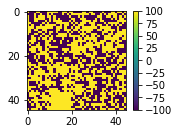

In [9]:
import matplotlib.pyplot as plt

#Illustration of a lens
plt.im = x[0].T
plt.subplot(221)
plt.imshow(im[:,:,0]); plt.colorbar()

# Using the Residual Neural Network

In [10]:
import sys
sys.path.append('/Users/sarafinanance/Desktop/CMUDeepLens_master')

from deeplens.resnet_classifier import deeplens_classifier
# reload(sys.modules['deeplens.resnet_classifier'])

In [11]:
model = deeplens_classifier(learning_rate=0.0001,  # Initial learning rate
                          learning_rate_steps=3,  # Number of learning rate updates during training
                          learning_rate_drop=0.1, # Amount by which the learning rate is updated
                          batch_size=128,         # Size of the mini-batch
                          n_epochs=50)           # Number of epochs for training

In [12]:
model.fit(x,y,xval,yval) # Train the model, the validation set is provided for evaluation of the model

Starting Epoch : 0
Epoch took 11.960147 s
Starting Epoch : 1
Epoch took 11.963407 s
Starting Epoch : 2
Epoch took 12.150538 s
Starting Epoch : 3
Epoch took 12.022912 s
Starting Epoch : 4
Epoch took 11.981912 s
Starting Epoch : 5
Iteration : 5 -> [Validation] Purity: 0.500000 ; Completeness: 1.000000
Iteration : 5 -> [Training] Purity: 0.583333 ; Completeness: 0.913043
Epoch took 11.966722 s
Starting Epoch : 6
Epoch took 12.094708 s
Starting Epoch : 7
Epoch took 13.025861 s
Starting Epoch : 8
Epoch took 12.049947 s
Starting Epoch : 9
Epoch took 11.912724 s
Starting Epoch : 10
Iteration : 10 -> [Validation] Purity: 0.500000 ; Completeness: 0.052632
Iteration : 10 -> [Training] Purity: nan ; Completeness: 0.000000
Epoch took 12.681022 s
Starting Epoch : 11
Epoch took 12.424039 s
Starting Epoch : 12
Epoch took 11.846880 s
Starting Epoch : 13
Epoch took 13.162629 s
Starting Epoch : 14
Epoch took 12.135370 s
Starting Epoch : 15
Iteration : 15 -> [Validation] Purity: 0.500000 ; Completeness: 

deeplens_classifier()

In [13]:
# Saving the model parameters
model.save('deeplens_params.npy')

saving to deeplens_params.npy...


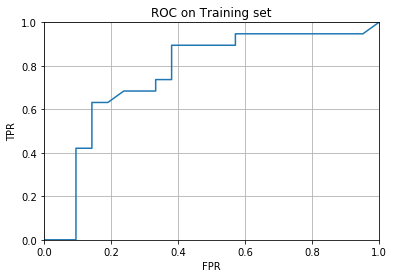

In [16]:
# Plot ROC curve on the training set [Warning: not very meaningful]
tpr,fpr,th = model.eval_ROC(xval,yval)
plt.title('ROC on Training set')
plt.plot(fpr,tpr)
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.xlim(0,1.0); plt.ylim(0,1.)
plt.grid('on')

In [ ]:
# Obtain predicted probabilities for each image
p = model.predict_proba(xval)